# Optimisation pour le réseau CIGRE adapté

## First Network


In [25]:
# Uploading the network from CIGRE

import pandapower as pp
import pandapower.networks as pn


global net_cigre
global s
global Vn
global N

net_cigre = pn.create_cigre_network_mv(with_der="pv_wind") # Network with PV and wing DER

'''
This pandapower network includes the following parameter tables:
  - switch (8 elements)
  - load (18 elements)
  - ext_grid (1 elements)
  - sgen (9 elements)
  - line (15 elements)
  - trafo (2 elements)
  - bus (15 elements)
  - bus_geodata (15 elements)
'''

'\nThis pandapower network includes the following parameter tables:\n  - switch (8 elements)\n  - load (18 elements)\n  - ext_grid (1 elements)\n  - sgen (9 elements)\n  - line (15 elements)\n  - trafo (2 elements)\n  - bus (15 elements)\n  - bus_geodata (15 elements)\n'

# Desestabilisation du réseau

Objectif : Avoir des sur tensions au niveau des GED

Premier pas : Augmenter le puissance dans les noeuds 1 et 12 (les plus proches de la source)
Deuxième pas : Chager les puissances des generateurs pour desestabiliser le réseau pour avoir des surtensions

In [26]:
# Changer la puissance d'un générateur

net_cigre.sgen.at[8,'p_mw'] = 15
net_cigre.sgen.at[8,'sn_mva'] = 15

# On prend le générateur 8 parce qu'il possède le plus de puissance déjà et des producteurs éoliens
# fournissent des puissances en général plus élévées

pp.create_sgen(net_cigre,bus=1,p_mw=5,q_mvar=5,sn_mva=5,name='WKA 1',type='WP')
pp.create_sgen(net_cigre,bus=12,p_mw=5,q_mvar=5,sn_mva=5,name='WKA 12',type='WP')

pp.runpp(net_cigre) # run the network

## Optimisation mono-objective with genetic algorithm

Dans cette partie, il est developpé le problème d'optimisation avec un nombre fixé de selfs (s) afin de pouvoir vérifier si l'optimisation fonctionne à la main. Le problème est définit de la manière suivante :

##### Variables : 

$(q,x) \in \mathbb{R}^N \times \{0,1\}^N$

$q = (q_i)_{1 \leq i \leq N}$, $q_i$ [MVAr] : puissance reactive de la self au noeud i, active si $x_i = 1$

$x = (x_i)_{1 \leq i \leq N}$, $x_i$ [-] : variable binaire qui indique si le noeud i a un self installé

##### Paramètres :

N [-] : quantité de noeuds du réseau

s [-] : quantité de selfs à installer

$V_n$ [kV] : tension nominal du réseau (20 kV pour un réseau HTA)

##### Formulation du problème

La formulation du problème est similaire de la formulation pour la résolution avec l'algorithme deterministe SLSQP. Nous l'avons reformulé parce que l'utilisation d'un problème mixe dans ce cas permet que l'algorithme traite la constrainte d'égalité pour les selfs. Le problème d'optimisation est décrit ci-dessous :


$$
\begin{aligned}
\min_{q,x} \quad & \sum_{i=1}^{N}{q_{i}}  \quad & \textrm{s.t.} \quad & V_{i} \leq V_{max}\\
\quad & \quad & \quad & V_{i} \geq V_{min}    \\
\quad & \quad & \quad & q_{i} \geq 0,2    \\
\quad & \quad & \quad & \sum_{i=1}^{N}{x_{i}} = s    \\
\end{aligned}
$$


### 1) Cas avec s = 1


In [32]:
def fct_model_reseau(x):
    
    ##Variables du modèle :
    
    q_self = x[0:13] # q_selfi[MVAr]: puissance reactive installée comme self à chaque noeud i
    pos = x[14::]# pos[-]: position des selfs actives

    ##Paramètres du modèle :
    
    # s[-]: nb de selfs à installer
    # Vn[kV]: tension nominal du réseau
    N = len(q_self) #N[-]: nb de noeuds du réseau (exclut le noeud source)
    
    ##Éliminant des selfs inclus par la dernière itération de l'algo
    i=len(net_cigre.shunt)-1
    if len(net_cigre.shunt) > 0:
        while i>=0:
            net_cigre.shunt.drop(i, inplace=True)
            i-=1

    ##Creer des shunts
    for index in range(N):
        if pos[index] == 1:
            pp.create_shunt(net=net_cigre,bus = index+1,q_mvar = q_self[index],p_mw = 0) #On utilise index +1 pour éviter le noeud source (bus 0)

    ##Calcul avec pandapower des tension dans les noeuds
    pp.runpp(net_cigre)
    V_noeud_aux = (net_cigre.res_bus['vm_pu'].values.tolist())
    V_noeud = [Vn*i for i in V_noeud_aux[1::]] #On prend toutes les tensions au réseau sauf la tension au noeud source (bus 0)


    ##Calcul des outputs
    outputs = np.array(V_noeud) # 0.95Vn<V<1.05Vn : contrainte de tension avec limite supérieur et inférieur

    return outputs



In [33]:
net_cigre.shunt

Empty DataFrame
Columns: [bus, name, q_mvar, p_mw, vn_kv, step, max_step, in_service]
Index: []

 The best solution found:                                                                           
 [11.55041874 13.18793045 14.65080309 13.95524621  6.09462918  9.93236724
 11.85393573  2.71539306 11.27984486  9.64887653  6.08382511 13.05032925
 12.39646966  3.4784001   0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.        ]

 Objective function:
 2.715393055559171


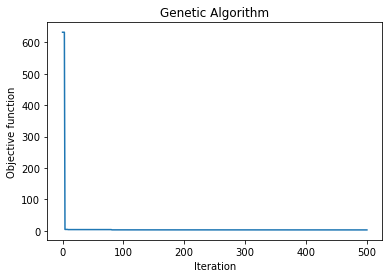

In [34]:
#Optimisations mono-objectif algo genetique
import numpy as np
import math
from geneticalgorithm import geneticalgorithm as ga

#Paramètres du modèle :

s = 1 # s[-]: nb de selfs à installer
Vn = 20 # Vn[kV]: tension nominal du réseau
N = 14 # N[-]: nb de noeuds du réseau

# Definisions les boundaries de la variables d'optimisation (qi peut être entre 0 et inf, si elle est active sa valeur minimale est 200 kVAr)
bounds =[]
for i in range(N):
    bounds.append([0,20])
for i in range(N):
    bounds.append([0,1])
bounds = np.array(bounds)

#Definisons des contraintes d'inégalité et égalité

lb_ineq_V =[]
ub_ineq_V =[]
lb_ineq_q =[]
ub_ineq_q =[]
lb_eq_s = s
ub_eq_s = s
for i in range(N):
    lb_ineq_V.append(0.95*Vn)
    ub_ineq_V.append(1.05*Vn)
for i in range(s):
    ub_ineq_q.append(math.inf)
    lb_ineq_q.append(0.2)

def nb_selfs(x):
    return sum(x[14::])

def q_installe(x):
    q_active_cons = []
    i=0
    for qi in x[0:14]:
        if x[14+i] == 1:
            q_active_cons.append(qi)
        i+=1
    return np.array(q_active_cons)

def f(x):
    try:
        pen=0
        #Première contrainte

        if nb_selfs(x)!= s:
            pen+=2000

        min_v = np.array(fct_model_reseau(x)).min()
        if min_v<np.array(lb_ineq_V)[1]:
            pen+=500*(np.array(lb_ineq_V)[1]-min_v)


        #Deuxième contrainte
        max_v = np.array(fct_model_reseau(x)).max()
        if max_v>np.array(ub_ineq_V)[1] :
            pen+=500*(max_v-np.array(ub_ineq_V)[1])
        
        #Troisième contrainte
        
        bad_q = q_installe(x).min()
        if bad_q<0.2:
            pen+=500*(0.2-bad_q)

        value = sum(q_installe(x))+pen
    except:
        value = 2000
    return value


#Solver

vartype=[]
for i in range(N):
    vartype.append(['real'])
for i in range(N):
    vartype.append(['int'])
vartype = np.array(vartype)

algorithm_param = {'max_num_iteration': 500,\
                   'population_size':100,\
                   'mutation_probability':0.2,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.7,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model=ga(function=f,dimension=28,variable_type_mixed=vartype,variable_boundaries=bounds,algorithm_parameters=algorithm_param)

model.run()

In [36]:
fct_model_reseau(model.output_dict['variable'])

array([19.98518522, 20.00178411, 20.20898757, 20.17608601, 20.15356064,
       20.12722783, 20.98449632, 20.40896291, 20.39184852, 20.37029119,
       20.36688574, 20.53250986, 20.43866471, 20.38467529])

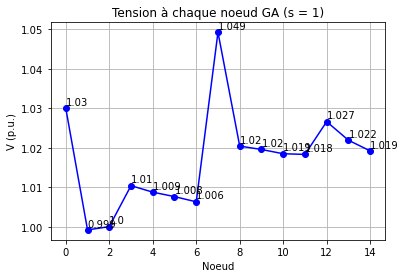

In [39]:
#Plotting the voltage with respect to the bus

import matplotlib.pyplot as plt
import numpy as np
    
# X axis parameter:
xaxis = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12, 13, 14])

# Y axis parameter:
yaxis = net_cigre.res_bus['vm_pu']

# Labels
plt.ylabel('V (p.u.)')
plt.xlabel('Noeud')

for i in range(len(yaxis)):
    plt.annotate(str(round(yaxis[i], 3)), xy=(xaxis[i], yaxis[i]+0.0008))

plt.grid()
plt.title('Tension à chaque noeud GA (s = 1)')
plt.plot(xaxis, yaxis, '-bo')
plt.show()

### 2) Cas avec s = 2

 The best solution found:                                                                           
 [17.87638558 12.27784849 13.41262498 11.76036348  1.93691878 18.00686292
  2.09736212 16.58772251 19.56871629  0.63785792 17.79027589 13.13907022
 10.01903465 11.72603883  0.          0.          0.          0.
  0.          0.          1.          0.          0.          1.
  0.          0.          0.          0.        ]

 Objective function:
 2.7352200451114217


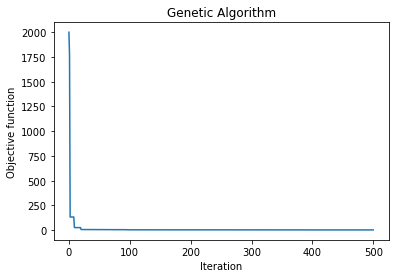

In [40]:
#Optimisations mono-objectif algo genetique
import numpy as np
import math
from geneticalgorithm import geneticalgorithm as ga

#Paramètres du modèle :

s = 2 # s[-]: nb de selfs à installer
Vn = 20 # Vn[kV]: tension nominal du réseau
N = 14 # N[-]: nb de noeuds du réseau

# Definisions les boundaries de la variables d'optimisation (qi peut être entre 0 et inf, si elle est active sa valeur minimale est 200 kVAr)
bounds =[]
for i in range(N):
    bounds.append([0,20])
for i in range(N):
    bounds.append([0,1])
bounds = np.array(bounds)

#Definisons des contraintes d'inégalité et égalité

lb_ineq_V =[]
ub_ineq_V =[]
lb_ineq_q =[]
ub_ineq_q =[]
lb_eq_s = s
ub_eq_s = s
for i in range(N):
    lb_ineq_V.append(0.95*Vn)
    ub_ineq_V.append(1.05*Vn)
for i in range(s):
    ub_ineq_q.append(math.inf)
    lb_ineq_q.append(0.2)

def nb_selfs(x):
    return sum(x[14::])

def q_installe(x):
    q_active_cons = []
    i=0
    for qi in x[0:N]:
        if x[N+i] == 1:
            q_active_cons.append(qi)
        i+=1
    return np.array(q_active_cons)

def f(x):
    try:
        pen=0
        #Première contrainte

        if nb_selfs(x)!= s:
            pen+=2000

        min_v = np.array(fct_model_reseau(x)).min()
        if min_v<np.array(lb_ineq_V)[1]:
            pen+=500*(np.array(lb_ineq_V)[1]-min_v)


        #Deuxième contrainte
        max_v = np.array(fct_model_reseau(x)).max()
        if max_v>np.array(ub_ineq_V)[1] :
            pen+=500*(max_v-np.array(ub_ineq_V)[1])
        
        #Troisième contrainte
        
        bad_q = q_installe(x).min()
        if bad_q<0.2:
            pen+=500*(0.2-bad_q)

        value = sum(q_installe(x))+pen
    except:
        value = 2000
    return value


#Solver

vartype=[]
for i in range(N):
    vartype.append(['real'])
for i in range(N):
    vartype.append(['int'])
vartype = np.array(vartype)

algorithm_param = {'max_num_iteration': 500,\
                   'population_size':100,\
                   'mutation_probability':0.2,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.7,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model2=ga(function=f,dimension=28,variable_type_mixed=vartype,variable_boundaries=bounds,algorithm_parameters=algorithm_param)

model2.run()

In [41]:
fct_model_reseau(model2.output_dict['variable'])
net_cigre.shunt

bus  name    q_mvar  p_mw  vn_kv  step  max_step  in_service
0    7  None  2.097362   0.0   20.0     1         1        True
1   10  None  0.637858   0.0   20.0     1         1        True

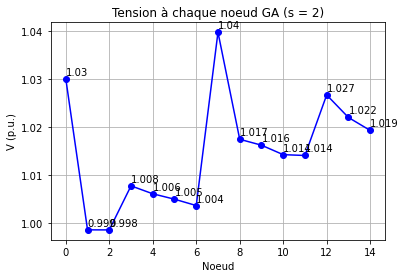

In [42]:
#Plotting the voltage with respect to the bus

import matplotlib.pyplot as plt
import numpy as np
    
# X axis parameter:
xaxis = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12, 13, 14])

# Y axis parameter:
yaxis = net_cigre.res_bus['vm_pu']

# Labels
plt.ylabel('V (p.u.)')
plt.xlabel('Noeud')

for i in range(len(yaxis)):
    plt.annotate(str(round(yaxis[i], 3)), xy=(xaxis[i], yaxis[i]+0.0008))

plt.grid()
plt.title('Tension à chaque noeud GA (s = 2)')
plt.plot(xaxis, yaxis, '-bo')
plt.show()

### 3) Cas avec s = 3

 The best solution found:                                                                           
 [ 0.91632427  0.39823684 18.07553807  6.94930761 11.81786686 18.80342505
 11.67001674 14.9398007   2.87593391  6.61982536  9.14249631 15.40103162
 18.96717542  4.33314254  1.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.        ]

 Objective function:
 4.19049501945376


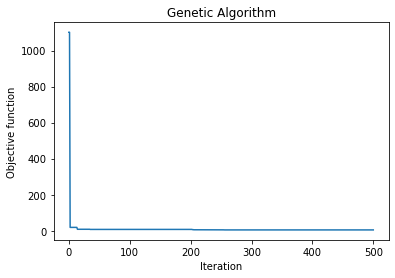

In [43]:
#Optimisations mono-objectif algo genetique
import numpy as np
import math
from geneticalgorithm import geneticalgorithm as ga

#Paramètres du modèle :

s = 3 # s[-]: nb de selfs à installer
Vn = 20 # Vn[kV]: tension nominal du réseau
N = 14 # N[-]: nb de noeuds du réseau

# Definisions les boundaries de la variables d'optimisation (qi peut être entre 0 et inf, si elle est active sa valeur minimale est 200 kVAr)
bounds =[]
for i in range(N):
    bounds.append([0,20])
for i in range(N):
    bounds.append([0,1])
bounds = np.array(bounds)

#Definisons des contraintes d'inégalité et égalité

lb_ineq_V =[]
ub_ineq_V =[]
lb_ineq_q =[]
ub_ineq_q =[]
lb_eq_s = s
ub_eq_s = s
for i in range(N):
    lb_ineq_V.append(0.95*Vn)
    ub_ineq_V.append(1.05*Vn)
for i in range(s):
    ub_ineq_q.append(math.inf)
    lb_ineq_q.append(0.2)

def nb_selfs(x):
    return sum(x[14::])

def q_installe(x):
    q_active_cons = []
    i=0
    for qi in x[0:N]:
        if x[N+i] == 1:
            q_active_cons.append(qi)
        i+=1
    return np.array(q_active_cons)

def f(x):
    try:
        pen=0
        #Première contrainte

        if nb_selfs(x)!= s:
            pen+=2000

        min_v = np.array(fct_model_reseau(x)).min()
        if min_v<np.array(lb_ineq_V)[1]:
            pen+=500*(np.array(lb_ineq_V)[1]-min_v)


        #Deuxième contrainte
        max_v = np.array(fct_model_reseau(x)).max()
        if max_v>np.array(ub_ineq_V)[1] :
            pen+=500*(max_v-np.array(ub_ineq_V)[1])
        
        #Troisième contrainte
        
        bad_q = q_installe(x).min()
        if bad_q<0.2:
            pen+=500*(0.2-bad_q)

        value = sum(q_installe(x))+pen
    except:
        value = 2000
    return value


#Solver

vartype=[]
for i in range(N):
    vartype.append(['real'])
for i in range(N):
    vartype.append(['int'])
vartype = np.array(vartype)

algorithm_param = {'max_num_iteration': 500,\
                   'population_size':100,\
                   'mutation_probability':0.2,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.7,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model3=ga(function=f,dimension=28,variable_type_mixed=vartype,variable_boundaries=bounds,algorithm_parameters=algorithm_param)

model3.run()

In [44]:
fct_model_reseau(model3.output_dict['variable'])
net_cigre.shunt

bus  name    q_mvar  p_mw  vn_kv  step  max_step  in_service
0    1  None  0.916324   0.0   20.0     1         1        True
1    2  None  0.398237   0.0   20.0     1         1        True
2    9  None  2.875934   0.0   20.0     1         1        True

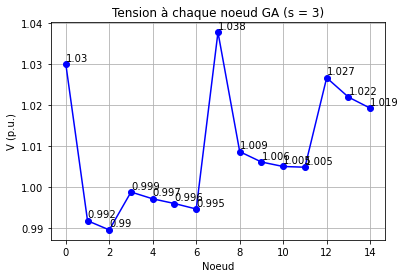

In [45]:
#Plotting the voltage with respect to the bus

import matplotlib.pyplot as plt
import numpy as np
    
# X axis parameter:
xaxis = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12, 13, 14])

# Y axis parameter:
yaxis = net_cigre.res_bus['vm_pu']

# Labels
plt.ylabel('V (p.u.)')
plt.xlabel('Noeud')

for i in range(len(yaxis)):
    plt.annotate(str(round(yaxis[i], 3)), xy=(xaxis[i], yaxis[i]+0.0008))

plt.grid()
plt.title('Tension à chaque noeud GA (s = 3)')
plt.plot(xaxis, yaxis, '-bo')
plt.show()

### 4) Cas avec s = 4

 The best solution found:                                                                           
 [13.34892679  9.78285379  3.50297038 15.97711263  0.27844877  2.39937937
  0.71745203  5.04726415 14.53232306 12.72048874  1.82087447  1.19710795
 16.26710037  0.25448946  0.          0.          0.          0.
  1.          0.          1.          0.          0.          0.
  1.          0.          0.          1.        ]

 Objective function:
 3.0712647304456286


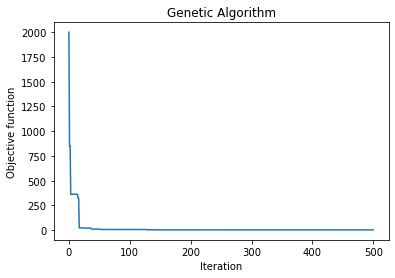

In [46]:
#Optimisations mono-objectif algo genetique
import numpy as np
import math
from geneticalgorithm import geneticalgorithm as ga

#Paramètres du modèle :

s = 4 # s[-]: nb de selfs à installer
Vn = 20 # Vn[kV]: tension nominal du réseau
N = 14 # N[-]: nb de noeuds du réseau

# Definisions les boundaries de la variables d'optimisation (qi peut être entre 0 et inf, si elle est active sa valeur minimale est 200 kVAr)
bounds =[]
for i in range(N):
    bounds.append([0,20])
for i in range(N):
    bounds.append([0,1])
bounds = np.array(bounds)

#Definisons des contraintes d'inégalité et égalité

lb_ineq_V =[]
ub_ineq_V =[]
lb_ineq_q =[]
ub_ineq_q =[]
lb_eq_s = s
ub_eq_s = s
for i in range(N):
    lb_ineq_V.append(0.95*Vn)
    ub_ineq_V.append(1.05*Vn)
for i in range(s):
    ub_ineq_q.append(math.inf)
    lb_ineq_q.append(0.2)

def nb_selfs(x):
    return sum(x[14::])

def q_installe(x):
    q_active_cons = []
    i=0
    for qi in x[0:N]:
        if x[N+i] == 1:
            q_active_cons.append(qi)
        i+=1
    return np.array(q_active_cons)

def f(x):
    try:
        pen=0
        #Première contrainte

        if nb_selfs(x)!= s:
            pen+=2000

        min_v = np.array(fct_model_reseau(x)).min()
        if min_v<np.array(lb_ineq_V)[1]:
            pen+=500*(np.array(lb_ineq_V)[1]-min_v)


        #Deuxième contrainte
        max_v = np.array(fct_model_reseau(x)).max()
        if max_v>np.array(ub_ineq_V)[1] :
            pen+=500*(max_v-np.array(ub_ineq_V)[1])
        
        #Troisième contrainte
        
        bad_q = q_installe(x).min()
        if bad_q<0.2:
            pen+=500*(0.2-bad_q)

        value = sum(q_installe(x))+pen
    except:
        value = 2000
    return value


#Solver

vartype=[]
for i in range(N):
    vartype.append(['real'])
for i in range(N):
    vartype.append(['int'])
vartype = np.array(vartype)

algorithm_param = {'max_num_iteration': 500,\
                   'population_size':100,\
                   'mutation_probability':0.2,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.7,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model4=ga(function=f,dimension=28,variable_type_mixed=vartype,variable_boundaries=bounds,algorithm_parameters=algorithm_param)

model4.run()

In [47]:
fct_model_reseau(model4.output_dict['variable'])
net_cigre.shunt

bus  name    q_mvar  p_mw  vn_kv  step  max_step  in_service
0    5  None  0.278449   0.0   20.0     1         1        True
1    7  None  0.717452   0.0   20.0     1         1        True
2   11  None  1.820874   0.0   20.0     1         1        True

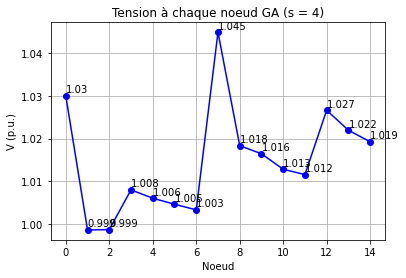

In [48]:
#Plotting the voltage with respect to the bus

import matplotlib.pyplot as plt
import numpy as np
    
# X axis parameter:
xaxis = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12, 13, 14])

# Y axis parameter:
yaxis = net_cigre.res_bus['vm_pu']

# Labels
plt.ylabel('V (p.u.)')
plt.xlabel('Noeud')

for i in range(len(yaxis)):
    plt.annotate(str(round(yaxis[i], 3)), xy=(xaxis[i], yaxis[i]+0.0008))

plt.grid()
plt.title('Tension à chaque noeud GA (s = 4)')
plt.plot(xaxis, yaxis, '-bo')
plt.show()